# Visualization of proteins and genes predictive of patient msi tumor metadata

In this notebook, the extracted genes from Proteomics and RNA-Seq notebooks are used to show their predictive power and visualize relations between themselves. Correaltion clustering with spearman distance measure were used. 

In [1]:
!ls
#######################################################################

Gender Visual.ipynb   Proteomics.ipynb      preprocess.py
Import.ipynb          RNA-Seq Final.ipynb   raw_data
MSI Visual.ipynb      RNA-Seq.ipynb
NA with RNA-Seq.ipynb __pycache__


In [2]:
import sys
import os
from IPython.utils import io
from io import StringIO

import re
import csv

import pandas as pd
import numpy as np
import scipy 
from scipy.cluster import hierarchy as hc # for dendograms 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook

from sklearn.metrics import f1_score # f1_score(y_true, y_pred)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

## Import & show data 

The initial data proprocess was done in the Import.ipynb notebook. The following three steps are performed in all other jupyter notebooks: run the preprocess.py code that was generated in Import.ipynb, run the %whos magic command to see what dataframes have been imported, and then format the captured %who results with pandas to view results. #### show the imported dataframes

In [4]:
%run preprocess.py
# made in Import.ipynb

In [6]:
with io.capture_output() as captured:
    %whos DataFrame 

s = re.findall(r'\S+|\n', StringIO(captured.stdout).getvalue())

In [7]:
table = []
row = []

for item in s:
    if (item == '\n'):
        if (row):
            table.append(row)
        row = []
    elif re.match('^(?!-)', item) is None:
        pass        
    else: 
        row.append(item)

for item in table: 
    if (item[0] == 'Variable'):
        pass
    else:
        item[2:] = [' , '.join(item[2:])]

df = pd.DataFrame(data=table[1:], columns=table[0])
pd.set_option('display.max_colwidth', -1)
df

,Variable,Type,Data/Info
0,df_test_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-High"
1,df_test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
2,df_test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"
3,df_train_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-Low/MSS"
4,df_train_mislabel,DataFrame,"sample , mismatch<...>79 , Training_80 , 1"
5,df_train_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
6,df_train_rna,DataFrame,"A1BG , A1<...>[80 , rows , x , 17447 , columns]"
7,test_cli,DataFrame,"gender , msi\n<...>\nTesting_80 , 1 , 1"
8,test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
9,test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"


In [21]:
# train_pro_combined
# train_rna_combined
train_combined.head()

,mismatch,gender,msi,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,ABCB4,ABCB5,ABCB6,...,XRCC4,XRCC5,XRCC6,XRN1,XRN2,YARS,YARS2,YBX1,YBX3,YIPF4,YIPF5,YIPF6,YKT6,YLPM1,YME1L1,YTHDF2,YTHDF3,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZADH2,ZAK,ZBED1,ZBTB7A,ZC3H11A,ZC3H13,ZC3H14,ZC3H15,ZC3H4,ZC3HAV1,ZC3HAV1L,ZCCHC8,ZFPL1,ZFR,ZG16,ZMPSTE24,ZMYM3,ZNF185,ZNF207,ZNF280C,ZNF326,ZNF638,ZNF706,ZPR1,ZW10,ZYX,ZZEF1
0,0,1,0,0.810976,0.294094,2.898144,6.548415,1.004192,2.519397,5.749835,5.043260,0.297011,4.504254,2.024335,5.403343,1.831152,5.165514,7.240806,0.177815,5.403007,0.409724,6.551073,3.100041,5.277979,3.298451,5.045930,1.001300,5.689962,0.969101,2.982777,2.366695,0.245197,3.066077,1.492358,0.053929,0.031171,3.255512,0.519140,0.096053,2.246003,0.349446,1.483484,1.022936,0.511371,3.912004,3.714960,0.155912,0.653988,0.175236,3.802488,...,0.969840,5.853167,5.692673,1.532790,3.632066,4.390283,2.785913,2.733676,2.341250,1.007287,1.006993,1.144088,2.698599,1.473819,1.917234,1.455458,1.493388,4.193716,5.192265,3.821649,4.017592,4.665611,6.300753,1.915149,1.620717,1.660843,1.030688,0.992511,1.652999,1.368638,1.630672,1.051260,2.915539,1.624048,1.040985,2.097838,2.657478,5.774241,2.280993,1.163372,1.165423,2.078553,1.530701,1.505944,1.007971,1.005565,1.016313,1.859706,3.834986,1.722888
1,1,1,0,0.340575,0.286721,2.223730,7.355751,0.967359,2.042327,5.949647,5.540432,0.633366,3.143702,2.852460,5.214069,1.350142,4.827544,7.442804,0.077730,4.881468,0.157388,6.859313,3.773362,4.681637,2.354399,3.245056,2.188932,6.038234,0.801714,1.874068,2.420736,0.830577,2.926069,0.687222,0.172355,0.105417,3.612654,1.402553,0.166862,2.521407,0.832623,2.273459,1.123911,0.736438,1.451913,3.560877,0.057962,0.930209,0.608913,4.382873,...,1.044018,5.759085,6.105171,0.993673,3.202251,2.857531,2.834447,3.542736,2.390906,1.007287,1.010723,1.144088,2.132064,2.413960,2.751047,1.632909,1.529682,5.019476,5.062740,3.819669,3.993814,4.389870,6.139485,1.945070,1.662572,1.660843,1.034917,0.995823,1.680459,1.368638,3.392088,2.212228,2.967906,1.312801,1.927286,0.970673,1.792636,3.260775,1.879562,1.163372,1.165423,2.560404,1.530701,2.515630,1.516790,1.009703,1.101494,1.465056,4.156957,1.722888
2,0,0,0,1.612506,0.347598,2.206560,7.045954,2.028455,2.829612,5.230059,4.257250,0.614350,3.063500,3.015768,5.307434,2.007040,5.816310,6.877159,0.110958,5.428458,0.526734,6.060380,3.069175,4.679611,2.549950,4.862690,2.131480,5.540457,2.389167,3.140561,2.544298,0.459123,2.113906,0.217318,0.454064,0.089015,3.405832,1.049774,0.094002,2.719581,0.838956,3.027581,0.836651,0.537880,3.916830,3.583882,0.174002,0.732249,0.567775,3.133188,...,0.974529,5.658831,5.743094,1.532790,2.816889,3.849770,1.258000,2.404759,1.602509,1.006134,1.079447,1.144088,3.002017,0.986676,1.814024,1.632909,1.403137,4.772247,5.047297,3.978143,3.574884,4.230233,5.876627,0.947357,1.072991,1.660843,1.034917,1.315018,1.703609,1.741504,2.703586,1.056045,3.298531,1.312801,1.569004,1.727459,2.115843,4.629868,2.353838,1.163372,1.019584,2.122499,1.530701,1.554500,1.303811,1.009703,1.019879,1.932920,4.303349,1.722888
3,0,1,0,0.768138,0.251778,2.996356,6.451277,1.142773,1.849382,5.526629,4.904821,0.721755,3.025762,2.844898,5.477457,1.477467,6.195029,6.779318,0.081480,5.484737,0.180940,6.266849,2.820478,4.246034,3.250814,4.857285,1.586813,5.563590,1.749705,2.600390,2.150795,0.358562,2.517248,0.493132,0.173244,0.194729,3.170614,1.066757,0.103360,2.310197,0.442474,2.064240,0.579675,0.309876,3.692298,4.082260,0.128512,0.608184,0.325630,2.352980,...,1.044018,5.698497,5.655790,1.532790,2.972644,4.141407,2.314568,2.888977,1.618239,1.007287,1.079447,1.144088,2.869346,0.999796,1.814024,1.011424,1.616613,3.784756,5.332163,2.703492,3.271345,4.095585,5.595029,1.244139,2.636959,1.660843,1.035846,1.521970,2.265474,1.368638,1.753413,1.847031,1

In [10]:
train_msi = train_combined [[ # msi proteomics
                             'TAP1', 'APOL2', 'LCP1', 'PTPN6', 'CASK', 
                             'UBE2L6', 'ICAM1', 'ITGB2',
                             'SDF2L1', 'CKB', 'LAP3', 'IFI30', 'PTPRC', 
                             'HSDL2', 'RFC2', 'WARS',
                             'IFI35', 'TYMP', 'CSRP2', 'TAPBP', 'ERMP1', 
                             'ANP32E', 'HP', 'HK3',
                             'ROCK2', 'ADPGK', 'HSPA4L', 'CNDP2', 'RFTN1',
                             'GBP1', 'GBP2', 'FMNL1',
                             'NCF2', 'YARS2', 'RPL3', 'SPTLC2', 'ENO1', 
                             'SNX12', 'DMBT1', 'ARL3',
    
                              # mis rna-seq 
                             'EPDR1', 'APOL3', 'POU5F1B', 'CFTR', 'CIITA',
                             'RAB32', 'MAX',
                             'PRSS23', 'FABP6', 'GABRP', 'LAP3', 'LY6G6D',
                             'SLC19A3', 'WARS',
                             'DLGAP1-AS5', 'GBP1', 'RAMP1', 'AREG', 
                             'GSPT2', 'TNFAIP2',
                             'EREG', 'TNNC2', 'ANKRD27', 'PLCL2', 
                             'TFCP2L1', 'LAG3', 'GRM8', 
                             'BEX2', 'DEFB1', 'FABP1', 'IRF1', 'CCL4', 
                             'SLC25A48', 'SLC51B', 
                             'TRIM72', 'GBP4', 'HPSE',]]
train_msi.head()

,TAP1,TAP1,APOL2,APOL2,LCP1,LCP1,PTPN6,PTPN6,CASK,CASK,UBE2L6,UBE2L6,ICAM1,ICAM1,ITGB2,ITGB2,SDF2L1,SDF2L1,CKB,CKB,LAP3,LAP3,IFI30,IFI30,PTPRC,PTPRC,HSDL2,HSDL2,RFC2,RFC2,WARS,WARS,IFI35,IFI35,TYMP,TYMP,CSRP2,CSRP2,TAPBP,TAPBP,ERMP1,ERMP1,ANP32E,ANP32E,HP,HP,HK3,HK3,ROCK2,ROCK2,...,SNX12,SNX12,DMBT1,DMBT1,ARL3,ARL3,EPDR1,APOL3,POU5F1B,CFTR,CIITA,RAB32,RAB32,MAX,PRSS23,FABP6,GABRP,LAP3,LAP3,LY6G6D,SLC19A3,WARS,WARS,DLGAP1-AS5,GBP1,GBP1,RAMP1,AREG,GSPT2,GSPT2,TNFAIP2,TNFAIP2,EREG,TNNC2,ANKRD27,PLCL2,TFCP2L1,LAG3,GRM8,BEX2,DEFB1,FABP1,FABP1,IRF1,CCL4,SLC25A48,SLC51B,TRIM72,GBP4,HPSE
0,4.651500,3.101133,4.247370,1.729173,5.632128,5.700658,5.374209,3.369945,4.154355,3.128102,5.769589,1.509587,3.251018,1.846918,4.292112,3.690378,6.153990,1.683073,10.674783,5.380663,6.368250,3.670234,8.026078,1.552930,4.042581,3.531650,5.352057,3.116319,5.415965,1.984686,6.411590,5.450480,4.940763,2.403461,4.663913,4.611946,4.122139,2.680458,4.251167,1.484965,5.392500,3.232196,4.324854,2.647740,0.607501,3.107639,1.803120,3.135466,5.182137,3.398468,...,5.401642,2.697267,4.352768,0.963112,3.267086,1.004921,5.068974,2.920203,3.869936,5.099391,1.186619,6.681547,1.755218,5.620318,7.998968,5.982100,0.646799,6.368250,3.670234,7.976046,4.799500,6.411590,5.450480,0.355432,4.523674,2.060046,3.443459,8.208215,3.336497,1.196881,2.867848,1.135348,5.794335,3.521783,4.554105,2.119821,3.323070,0.575925,2.604495,1.556961,6.038161,10.186393,3.659614,4.705455,3.882035,0.826417,4.218747,0.064427,2.367298,2.258082
1,4.907230,3.201951,3.986794,0.976821,3.796106,5.169007,5.599023,3.571890,4.235484,3.942006,5.461456,1.006684,3.688235,1.880945,3.059149,2.418586,6.182927,1.981326,7.018052,2.075542,5.271563,4.402180,6.059295,1.007091,2.269137,3.128083,5.133011,4.107333,5.199796,2.017740,7.077079,4.765848,5.095093,1.557414,3.431182,3.772282,4.080498,1.826178,5.896692,2.311066,4.493037,2.528123,4.609470,2.473567,0.152414,4.404806,0.926048,2.887179,5.275023,2.623666,...,5.258292,1.892991,2.709942,2.316187,3.878341,2.420171,3.671652,3.661320,0.819895,2.544814,1.385802,4.861392,0.967254,5.321845,4.944090,3.676068,2.165778,5.271563,4.402180,2.024731,0.283180,7.077079,4.765848,0.355432,2.997289,1.150346,5.918686,2.942027,2.287729,1.196881,3.014739,1.709046,0.491910,3.463483,4.372636,3.004773,4.646793,1.117773,0.340012,2.835360,2.925058,4.028863,2.926431,4.698832,2.157183,0.143012,0.505979,2.944485,1.837402,1.514125
2,4.798941,3.124638,3.990949,0.976821,5.032345,5.289991,5.404629,3.596531,4.470647,3.306025,5.657584,1.640503,4.196945,1.909636,4.017248,2.648528,5.729560,2.510110,8.369162,5.297963,5.679534,4.282815,7.921393,1.007091,3.478986,2.341193,5.051220,3.617252,5.464066,0.927270,6.290603,5.062525,4.783647,2.241183,5.428118,4.129270,4.435193,2.349896,5.483897,2.285687,5.048951,3.268108,4.810142,3.259689,2.671395,4.007967,1.346111,1.106836,4.770779,3.098915,...,5.456815,2.262998,3.857408,0.966703,3.225434,1.537651,5.228504,3.220894,3.596637,6.074729,1.829494,6.011091,1.542292,5.904843,6.215481,3.903497,0.445434,5.679534,4.282815,6.757167,2.051195,6.290603,5.062525,0.161357,4.109993,2.912861,4.055472,5.191340,2.657861,1.196881,4.447246,1.709046,4.983040,5.320197,4.509670,2.554536,4.331052,1.099517,4.985691,2.686902,3.402360,11.272918,4.981328,4.528903,3.558163,0.498904,4.752887,0.333649,3.140490,2.106443
3,5.393004,2.834194,3.700651,2.195597,5.312986,5.255789,5.350994,2.898613,5.210874,3.280569,7.034161,1.640511,3.877645,1.927817,4.232269,2.628464,5.903448,1.462462,9.270209,5.772039,6.575479,4.925373,7.410671,1.510015,4.046934,2.535088,5.902457,3.262631,5.407025,0.939209,6.913497,5.111046,5.209759,1.646310,4.882842,4.213196,4.439307,3.967258,4.561391,2.048287,5.091505,3.463893,4.539646,2.234228,0.563115,4.387736,1.310954,1.120556,4.557468,2.152635,...,6.050956,3.235579,1.205263,2.022300,3.814751,2.394171,5.412139,4.105696,2.611039,7.040138,1.553291,6.620644,1.631276,5.624004,5.461973,5.690553,1.513595,6.575479,4.925373,4.167518,2.562546,6.913497,5.111046,0.089273,4.758492,2.821579,3.

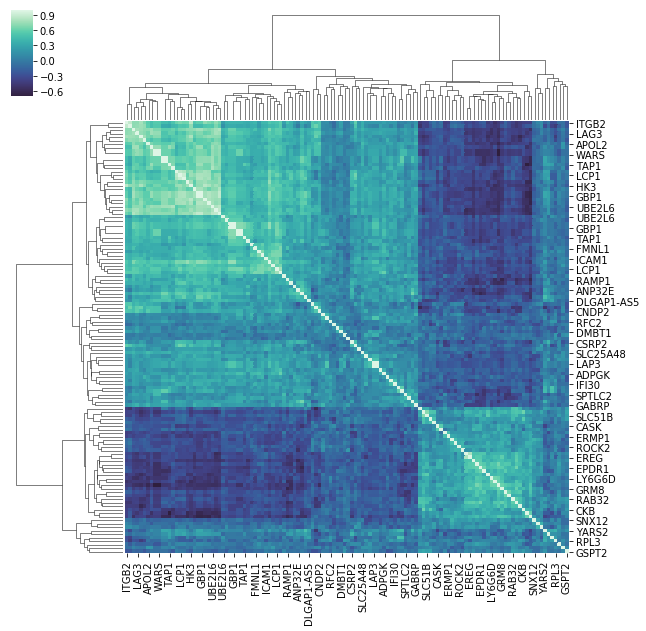

In [11]:
sns.clustermap(train_msi.corr(method='spearman'), center=0, cmap="mako")

In [14]:
train_msi_na = train_combined [[ # msi proteomics with > 90% availability 
                                'TAP1', 'LCP1', 'PTPN6', 'CASK', 'ICAM1', 
                                'ITGB2', 'ANP32E', 'ARL3',
                                'CKB', 'LAP3', 'PTPRC', 'HSDL2', 'WARS',
                                'IFI35', 'TYMP', 'TAPBP', 'ERMP1', 
                                'ROCK2', 'CNDP2', 'RFTN1', 'GBP1',
                                'NCF2', 'YARS2', 'RPL3', 'ENO1', 'SNX12',
                                
                                # mis rna-seq with > 90% availability 
                                'EPDR1', 'APOL3', 'POU5F1B', 'CFTR', 
                                'CIITA', 'MAX', 'GBP4', 'HPSE',
                                'PRSS23', 'FABP6', 'GABRP', 'LAP3', 
                                'SLC19A3', 'WARS',
                                'GBP1', 'RAMP1', 'AREG',
                                'EREG', 'TNNC2', 'ANKRD27', 'PLCL2', 
                                'TFCP2L1', 'LAG3', 'GRM8', 
                                'BEX2', 'DEFB1', 'IRF1', 'CCL4','SLC51B', 
                                ]]
columns = train_msi_na.columns

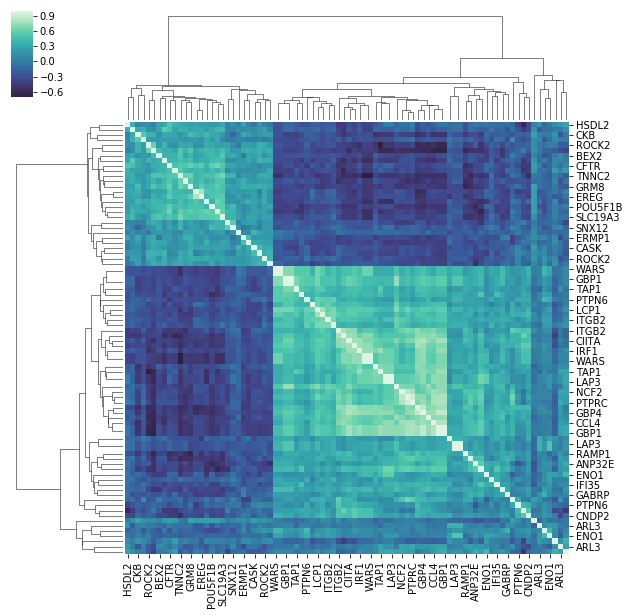

In [20]:
sns.clustermap(train_msi_na.corr(method='spearman'),
               center=0, 
               cmap="mako")

#### It is shown in the end that combining data from proteomics and RNA-seq analyses imporves the predictive power of the classifer compared to those shown individually in each respective dataset and notebook.

In [17]:
X_msi_train, X_msi_valid, y_msi_train, y_msi_valid =\
\
    train_test_split(train_msi_na.values.astype(int),
                     train_combined.msi.values,
                     test_size=0.3)

 1) CIITA                          0.136071
 2) GRM8                           0.135375
 3) IFI35                          0.120808
 4) TNNC2                          0.118044
 5) POU5F1B                        0.097760
 6) HPSE                           0.045045
 7) BEX2                           0.037023
 8) ERMP1                          0.029590
 9) APOL3                          0.025180
10) TAP1                           0.023508
11) ITGB2                          0.016173
12) IRF1                           0.014562
13) TAPBP                          0.012421
14) GBP4                           0.011735
15) HSDL2                          0.009778
16) CNDP2                          0.008857
17) ANP32E                         0.008309
18) WARS                           0.007520
19) WARS                           0.007478
20) PTPN6                          0.007206
21) TAP1                           0.007138
22) CKB                            0.006825
23) GBP1                        

<BarContainer object of 84 artists>

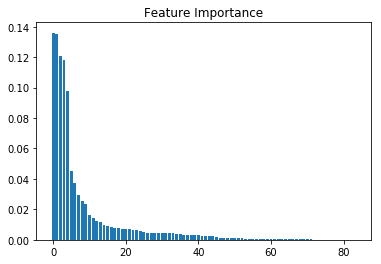

In [18]:
msi_forest = RandomForestClassifier(n_estimators=500, 
                                      min_samples_leaf=3,
                                      max_features=None,
                                      n_jobs=-1,
                                      oob_score=True)

msi_forest.fit(X_msi_train, y_msi_train)

msi_importances = msi_forest.feature_importances_
msi_indices = np.argsort(msi_importances)[::-1]

# for f in range(X_train.shape[1]): # to get the full results
for f in range(len(columns)):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[msi_indices[f]], 
                            msi_importances[msi_indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_msi_train.shape[1]), 
        msi_importances[msi_indices], 
        align='center')

In [19]:
msi_select = SelectFromModel(msi_forest, threshold=0.00)

msi_select.fit(X_msi_train, y_msi_train)

X_msi_important_train = msi_select.transform(X_msi_train)
X_msi_important_train_df = pd.DataFrame(X_msi_important_train)
X_msi_important_valid = msi_select.transform(X_msi_valid)
msi_forest.fit(X_msi_important_train, y_msi_train)
y_msi_pred = msi_forest.predict(X_msi_important_valid)
print('Random Forest: \n', 
      classification_report(y_true=y_msi_valid, y_pred=y_msi_pred))
print('OOB score: ', msi_forest.oob_score_)

Random Forest: 
              precision    recall  f1-score   support

          0       0.81      1.00      0.89        17
          1       1.00      0.43      0.60         7

avg / total       0.87      0.83      0.81        24

OOB score:  0.9107142857142857


### same process as Gender Visual Notebook